In [32]:
###### valido para Julia 1.7.2
using LinearAlgebra
using Plots
using Graphs #paquetería para graphos
using Random
using GraphPlot #paqueteria para graficar redes
using SparseArrays
using LaTeXStrings

In [33]:
fnt = Plots.font("sans-serif", 15) # Para gráficar loas labels


Plots.Font("sans-serif", 15, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,0.0))

In [36]:
F(theta,i,j,k)=exp(im*theta*i*j/k) #son las entradas de la matriz, las exponenciales

function Coin_Fourier(k,theta=2*pi)   #genera la matriz
    
    Cki=zeros(Complex,k,k)

    
    Cki[1,:].=1                # se le agrega 1's a la primera fila
    Cki[:,1].=1                # se le agrega 1's a la primera columna
    for i=1:k-1                #  En este for se va a recorrer cada fila y columna
        for j=1:k-1               ## junto con este otro for
            Cki[j+1,i+1]=F(theta,i,j,k) # se utiliza la función F que se definio arriba
        end
    end
    
    if k==2
        
        ###Este es un parche para un anillo##
        C=zeros(2,2)
        C[1,1]=0
        C[1,2]=1
        C[2,1]=1
        C[2,2]=0
        ######################################
       return (1/sqrt(k))*(Cki*C)  # se le multiplica por el 1/sqrt(grado) al que corresponde 
    else
       return (1/sqrt(k))*(Cki) 
    end
end


## Neceisto algo que si le doy un nodo me diga que base se le asigna###
function Base_del_Nodo(Nodo,A)
    k=sum(A[Nodo,:]) # Sumamos cada entrada eso nos dará el grado del nodo
    Id=Matrix(1I, k, k) # generamos la matriz identidad que corresponde al grado
    return Id #La retorna
              ## Esto genera la base segun sea el grado de cada nodo
end

Base_del_Nodo (generic function with 1 method)

In [37]:
function U_evolution(n,A,ψ)

    ### Para ver que vectores hay tenemos que recorrer cada uno... PARA UNA MATRIZ ψ DADA
    for t=1:n
        for i=1:size(A)[1]   #PAra un nodo i me va a dar el vector que le corresponde Ö

            if rowvals(ψ[i,:])==[]       # si no hay ningún peso entonces continua
               continue 
            else
               #println(ψ[i,:]) 
            end

            Nodos_de_i=rowvals(A[i,:])   # vecinos del nodo i
            Basis=Base_del_Nodo(i,A)     # base del nodo i


            v=zeros(length(Nodos_de_i)) # el vector del nodo i
            for (index,value) in enumerate(Nodos_de_i)   # hacemos dos indices uno que enlista los elemntos y otro los nodos conectados al nodos i
            v+=Basis[:,index]*ψ[i,value]
            end


            #Al vector le aplicamos el operador moenda
            k=sum(A[i,:])  # calculamos
            v=Coin_Fourier(k)*v  ## El vector despues de la moenda de Fourier 


            ## Hay que reemplazar los pesos (SEGUIMOS EN EL NODO 1)
            for (index,value) in enumerate(Nodos_de_i)   # hacemos dos indices uno que enlista los elemntos y otro los nodos conectados al nodos 1
                ψ[i,value]=v[index]
            end
        end
        ### operador S### es solo el trasnpuesto de la matriz ψ
        ψ=sparse(transpose(ψ))
    end
    return ψ
end

U_evolution (generic function with 1 method)

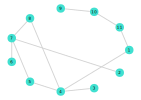

In [157]:
#Red de prueba
NODOS=11

g = SimpleGraph(NODOS)  #defeinimos nodos de 1 al 3

for i=1:NODOS-1
   add_edge!(g,i,i+1)  
end
add_edge!(g,NODOS,1)

#add_edge!(g,90,7)

#gplot(g, nodelabel=1:NODOS,layout=circular_layout)   #graficamos la red

gplot(watts_strogatz(NODOS,2,0.5), nodelabel=1:NODOS,layout=circular_layout)

In [116]:
A=adjacency_matrix(g);

In [117]:
Nd_central=Int64((NODOS-1)/2 +1)

51

In [118]:
ψ=sparse(zeros(Complex,size(A))) ## Creo la matriz de coeficientes psi

## Creamos un estado 
ψ[Nd_central,Nd_central+1]=1/sqrt(2) * 1     
ψ[Nd_central,Nd_central-1]=1/sqrt(2) * 1*im 

0.0 + 0.7071067811865475im

In [119]:
B=U_evolution(1000,A,ψ)
BB=abs2.(Matrix(B));

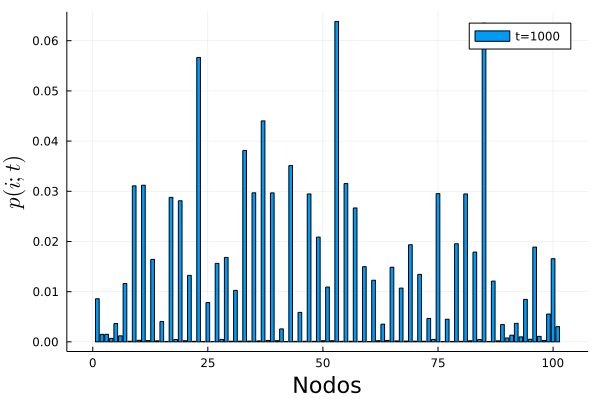

In [120]:
# pesos=zeros(size(A)[1])
for i=1:length(pesos)
    pesos[i]=sum(BB[i,:])
end
bar(pesos,guidefont=fnt,ylabel=L"p(i;t)",xlabel="Nodos",label="t=1000")

# Entropia
Solo sirve para quiralidad uniforme es decir en este caso 2

In [121]:
### Buscamos el grado más alto
grado_m=0
for i=1:NODOS
    if sum(A[i,:])>grado_m
        grado_m=sum(A[i,:])
    end
end
Q=grado_m
#####
function Density_M_Q(Q,A,ψ)
    Dst=zeros(ComplexF64,Q,Q)
    for m=1:NODOS
        for (jk,val_jk) in enumerate(rowvals(A[m,:]))
            for (jkp,val_jkp) in enumerate(rowvals(A[m,:]))
                #println(val_jk," ",val_jkp)
                Dst[jk,jkp]+=ψ[m,val_jk]*conj(ψ[m,val_jkp])  
            end
        end
    end
    return Dst
end

Density_M_Q (generic function with 1 method)

In [122]:
n=250
Sn=zeros(n)

for i=1:n
    Dst=Density_M_Q(Q,A,U_evolution(i,A,ψ))
    lamb=eigvals(Dst)
    for j=1:Q
        if lamb[j]<=0
            continue
        else
            Sn[i]-=lamb[j]*log(lamb[j])
        end
    end
end

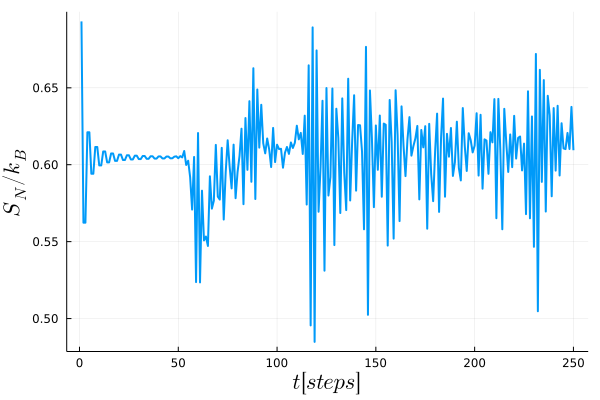

In [123]:
plot(Sn,ylabel=L"S_N/k_B",xlabel=L"t[steps]",label=false,
    guidefont=fnt,legend=:bottomright,
    legendfontsize=12.0,lw = 2)

# Cosos Pruebas

In [79]:
eigvals(Density_M_Q(Q,A,U_evolution(13,A,ψ)))

3-element Vector{Float64}:
 0.0
 0.2973632812499345
 0.702636718749845

In [313]:
#=
kk=0
for j=1:NODOS
    for i in rowvals(A[j,:])
        kk+=1
        println(kk,":","U|",j,"-->",i,">")
        for k in rowvals(A[j,:])
            println("\t(",Ayudaaa[(k,j)],",",Ayudaaa[(j,i)],")<",k,"-->",j,"|U|",j,"-->",i,">")
        end
    end
end
=#

In [314]:
Base_to_num=Dict()
kk=0
for j=1:NODOS
    for i in rowvals(A[j,:])
        kk+=1
        #println(kk,":","U|",j,"-->",i,">")
        Base_to_num[(j,i)] = kk;
    end
end


In [315]:
U=zeros(Complex,length(rowvals(A)),length(rowvals(A)))
ψ=sparse(zeros(Complex,size(A))) ## Creo la matriz de coeficientes psi
for j=1:NODOS
    for i in rowvals(A[j,:])
        ψ[j,i]=1
        K=U_evolution(1,A,ψ)[:,j]
        #println("U|",j,"-->",i,">")
        
        for k in rowvals(A[j,:])
           #println(ψ[j,k],"\t\t\t|",k,"-->",j,">")
            U[Base_to_num[(k,j)],Base_to_num[(j,i)]]=ψ[j,k]
        end
        
        ψ=sparse(zeros(Complex,size(A))) ## Creo la matriz de coeficientes psi
    end
end
U[1:2,1:2]

2×2 Matrix{Complex}:
 0+0im  0+0im
 0+0im  0+0im

In [316]:
subU=U[3:5,1:2]
transpose(subU)*subU

2×2 Matrix{Any}:
 0.5+0.0im  0.5+0.0im
 0.5+0.0im  0.5+0.0im

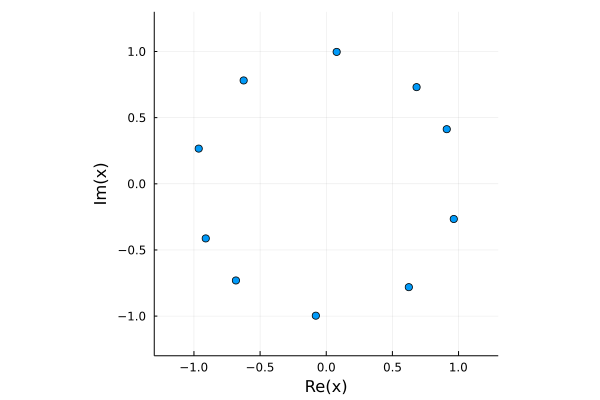

In [417]:
scatter(eigvals(Matrix{Complex}(U^1))
    ,aspect_ratio=:equal,xlims=(-1.3,1.3),ylims=(-1.3,1.3)
    ,label=false)

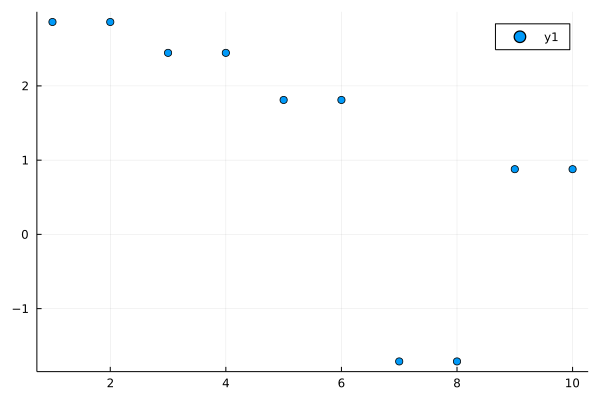

In [430]:
scatter(angle.(eigvals(Matrix{Complex}(U^1000))))

In [409]:
dimQ(N,M)=(N*N)^M
dimF(N,M)=factorial(M+N-1)/(factorial(M)*factorial(N-1))

dimF (generic function with 1 method)

In [414]:
M=1:10
dimQ.(4,M)

10-element Vector{Int64}:
            16
           256
          4096
         65536
       1048576
      16777216
     268435456
    4294967296
   68719476736
 1099511627776

In [416]:
dimF.(4,M)

10-element Vector{Float64}:
   4.0
  10.0
  20.0
  35.0
  56.0
  84.0
 120.0
 165.0
 220.0
 286.0

In [482]:
Uf=zeros(Complex,NODOS,NODOS)
Uf[2,1]=1/sqrt(2)
Uf[4,1]=1/sqrt(2)

Uf[1,2]=1/sqrt(3)
Uf[3,2]=1/sqrt(3)
Uf[4,2]=1/sqrt(3)

Uf[2,3]=1/sqrt(2)
Uf[4,3]=1/sqrt(2)

Uf[1,4]=1/sqrt(3)
Uf[2,4]=1/sqrt(3)
Uf[3,4]=1/sqrt(3)
Uf

4×4 Matrix{Complex}:
        0+0im    0.57735+0.0im         0+0im    0.57735+0.0im
 0.707107+0.0im        0+0im    0.707107+0.0im  0.57735+0.0im
        0+0im    0.57735+0.0im         0+0im    0.57735+0.0im
 0.707107+0.0im  0.57735+0.0im  0.707107+0.0im        0+0im

In [484]:
Uf*[0,0,0,1]

4-element Vector{Any}:
 0.5773502691896258 + 0.0im
 0.5773502691896258 + 0.0im
 0.5773502691896258 + 0.0im
                0.0 + 0.0im

In [487]:
transpose(Uf)*Uf

4×4 Matrix{Any}:
      1.0+0.0im  0.408248+0.0im       1.0+0.0im  0.408248+0.0im
 0.408248+0.0im       1.0+0.0im  0.408248+0.0im  0.666667+0.0im
      1.0+0.0im  0.408248+0.0im       1.0+0.0im  0.408248+0.0im
 0.408248+0.0im  0.666667+0.0im  0.408248+0.0im       1.0+0.0im